# Uber Ride Cancellation Predictor

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

## Exploratory Analysis

In [2]:
def load_data(filepath):
    """
    Loads the dataset from a specified CSV file.
    Args:
        filepath (str): The path to the CSV file.
    Returns:
        pd.DataFrame: The loaded data as a pandas DataFrame.
    """
    df = pd.read_csv(filepath)
    return df

In [3]:
def get_basic_info(df):
    """
    Provides basic information about the DataFrame.
    Args:
        df (pd.DataFrame): The input DataFrame.
    Returns:
        dict: A dictionary containing the shape and column names.
    """
    info = {
        'shape': df.shape,
        'columns': df.columns.tolist()
    }
    return info

In [77]:
def calculate_cancellation_rate(df):
    """
    Calculates the overall cancellation rate and plots booking status distribution.
    Args:
        df (pd.DataFrame): The input DataFrame.
    Returns:
        float: The cancellation rate (0-1).
    """
    cancelled_statuses = ['Cancelled by Customer', 'Cancelled by Driver']
    cancelled_rides = df['Booking Status'].isin(cancelled_statuses).sum()
    total_rides = len(df)
    cancellation_rate = cancelled_rides / total_rides

    # Plot cancellation vs completed
    plt.figure(figsize=(6,4))
    counts = df['Booking Status'].value_counts()
    counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Booking Status Distribution')
    plt.ylabel('Count')
    plt.show()

    return cancellation_rate

In [73]:
def find_vehicle_with_most_cancellations(df):
    """
    Finds the vehicle type with the highest number of cancellations.
    Args:
        df (pd.DataFrame): The input DataFrame.
    Returns:
        str: The name of the vehicle type with the most cancellations.
    """
    cancelled_statuses = ['Cancelled by Customer', 'Cancelled by Driver']
    cancelled_rides = df[df['Booking Status'].isin(cancelled_statuses)]
    
    # Plot cancellations by vehicle type
    plt.figure(figsize=(8,5))
    cancelled_rides['Vehicle Type'].value_counts().plot(kind='bar', color='salmon', edgecolor='black')
    plt.title('Cancellations by Vehicle Type')
    plt.ylabel('Count')
    plt.show()
    
    vehicle_most_cancellations = cancelled_rides['Vehicle Type'].mode()[0]
    return vehicle_most_cancellations

In [28]:
def find_top_customer_cancellation_reason(df):
    """
    Finds the most common reason provided by customers for cancelling.
    Args:
        df (pd.DataFrame): The input DataFrame.
    Returns:
        str: The most frequent cancellation reason, or 'No data' if none found.
    """
    reasons = df['Reason for cancelling by Customer'].dropna()
    
    # Plot top 5 reasons
    plt.figure(figsize=(8,5))
    if not reasons.empty:
        reasons.value_counts().head(5).plot(kind='bar', color='lightgreen', edgecolor='black')
        plt.title('Top 5 Customer Cancellation Reasons')
        plt.ylabel('Count')
        plt.show()
        top_reason = reasons.mode()[0]
    else:
        print("No customer cancellation reasons available to plot.")
        top_reason = 'No data'
    
    return top_reason

In [78]:
def find_peak_cancellation_hour(df):
    """
    Finds the hour of the day with the most cancellations.
    Args:
        df (pd.DataFrame): The input DataFrame.
    Returns:
        int: The hour (0–23) with the highest number of cancellations.
             Returns 0 if no cancellations exist.
    """
    cancelled_statuses = ['Cancelled by Customer', 'Cancelled by Driver', 'No Driver Found', 'Incomplete']
    
    # Filter cancelled rides
    cancelled_rides = df[df['Booking Status'].isin(cancelled_statuses)].copy()
    
    # Parse the Time column robustly
    cancelled_rides['Hour'] = pd.to_datetime(cancelled_rides['Time'], format='%H:%M:%S', errors='coerce').dt.hour
    
    # Drop rows where hour could not be parsed
    cancelled_rides = cancelled_rides.dropna(subset=['Hour'])
    
    # Convert Hour to integer
    cancelled_rides['Hour'] = cancelled_rides['Hour'].astype(int)
    
    # Plot cancellations by hour
    if not cancelled_rides.empty:
        plt.figure(figsize=(8,5))
        cancelled_rides['Hour'].value_counts().sort_index().plot(kind='bar', color='purple', edgecolor='black')
        plt.title('Cancellations by Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Count')
        plt.show()
    
    # Return 0 if no cancellations exist
    if cancelled_rides.empty:
        return 0
    
    # Return the hour with the highest cancellations (first in case of tie)
    return int(cancelled_rides['Hour'].mode()[0])

## Data Cleaning

In [68]:
def create_target_variable(df):
    """
    Creates the binary target variable 'is_cancelled' and filters the DataFrame safely.
    Args:
        df (pd.DataFrame): The raw input DataFrame.
    Returns:
        pd.DataFrame: A DataFrame with the new 'is_cancelled' column and filtered rows.
    """
    df.columns = df.columns.str.strip()  # remove whitespace
    if "Booking Status" not in df.columns:
        raise ValueError(f"'Booking Status' column not found. Columns present: {df.columns.tolist()}")

    # Clean status values
    df["Booking Status"] = df["Booking Status"].astype(str).str.strip().str.title()

    cancelled_statuses = ["Cancelled By Customer", "Cancelled By Driver", "No Driver Found"]
    completed_status = ["Completed"]

    filtered_df = df[df["Booking Status"].isin(cancelled_statuses + completed_status)].copy()

    if filtered_df.empty:
        print("Warning: No rows matched cancellation or completion statuses. Returning unfiltered data.")
        filtered_df = df.copy()

    filtered_df["is_cancelled"] = filtered_df["Booking Status"].isin(cancelled_statuses).astype(int)
    return filtered_df

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

def feature_engineering(df):
    """
    Creates new features from existing columns.
    Args:
        df (pd.DataFrame): The input DataFrame with 'Date' and 'Time' columns.
    Returns:
        pd.DataFrame: The DataFrame with a new 'hour_of_day' feature.
    """
    df_copy = df.copy()

    # Parse 'Time' column safely (only time part)
    df_copy['Time'] = pd.to_datetime(df_copy['Time'], format='%H:%M:%S', errors='coerce')

    # Drop rows with invalid/missing Time
    df_copy = df_copy.dropna(subset=['Time'])

    # Create 'hour_of_day' feature
    df_copy['hour_of_day'] = df_copy['Time'].dt.hour

    # Plot distribution of rides by hour
    if not df_copy['hour_of_day'].empty:
        plt.figure(figsize=(8,5))
        df_copy['hour_of_day'].value_counts().sort_index().plot(
            kind='bar', color='orange', edgecolor='black'
        )
        plt.title('Rides by Hour of Day')
        plt.xlabel('Hour of Day')
        plt.ylabel('Number of Rides')
        plt.show()

    return df_copy

In [11]:
def drop_unnecessary_columns(df):
    """
    Drops columns that are not needed for modeling.
    Args:
        df (pd.DataFrame): The input DataFrame.
    Returns:
        pd.DataFrame: The DataFrame with unnecessary columns removed.
    """
    cols_to_drop = ['Booking Status', 'Cancelled Rides by Customer', 'Reason for Cancelling by Customer',
                    'Cancelled Rides by Driver', 'Driver Cancellation Reason', 'Incomplete Rides',
                    'Incomplete Rides Reason', 'Ride Distance', 'Booking Value', 'Driver Ratings',
                    'Customer Rating', 'Booking ID', 'Customer ID', 'Date', 'Time']
    existing_cols = [col for col in cols_to_drop if col in df.columns]
    df_cleaned = df.drop(columns=existing_cols)
    return df_cleaned

In [90]:
def clean_and_save_data(input_filepath, output_filepath):
    """
    Orchestrates the entire data cleaning pipeline and saves the result.
    Ensures rows aren't accidentally dropped during imputation.
    """
    print("Starting data cleaning process...")

    # Load the raw data
    raw_df = pd.read_csv(input_filepath)
    print(f"Loaded {len(raw_df)} rows from {input_filepath}")

    raw_df.replace('null', np.nan, inplace=True)
    print("Replaced 'null' with NaN.")

    # Step 1 — Create target variable
    df_with_target = create_target_variable(raw_df)
    print(f"Step 1: Created target variable. Rows remaining: {len(df_with_target)}")

    # Step 2 — Feature engineering
    print("Step 2: Engineered 'hour_of_day' feature and plotted distribution.")
    df_featured = feature_engineering(df_with_target)

    # Step 3 — Handle missing values safely
    print("Step 3: Imputing missing values...")
    df_imputed = df_featured.copy()

    # Convert numeric columns safely, filling invalid values with mean (not drop)
    for col in ['Avg VTAT', 'Avg CTAT']:
        if col in df_imputed.columns:
            df_imputed[col] = pd.to_numeric(df_imputed[col], errors='coerce')
            df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mean())

    # Replace remaining NaNs with "Unknown" (for categorical columns)
    for col in df_imputed.select_dtypes(include=['object']).columns:
        df_imputed[col] = df_imputed[col].fillna("Unknown")

    print(f"Imputation complete. Rows remaining: {len(df_imputed)}")

    # Step 4 — Drop only truly unnecessary columns
    df_cleaned = drop_unnecessary_columns(df_imputed)
    print("Step 4: Dropped unnecessary columns.")
    print("Final columns:")
    for col in df_cleaned.columns:
        print(f" - {col}")

    # Save cleaned data
    df_cleaned.to_csv(output_filepath, index=False)
    print(f"Data cleaning complete. Cleaned data saved to {output_filepath}")

## Model Training

In [13]:
def prepare_data(df):
    """
    Prepares the data for modeling by separating features and target,
    and applying one-hot encoding to categorical features.
    """
    y = df['is_cancelled']
    X = df.drop(columns='is_cancelled')

    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

    feature_columns = X_encoded.columns.tolist()
    return X_encoded, y

In [14]:
def split_data(X, y):
    """
    Splits the data into training and testing sets using stratification.
    """
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
def train_model(X_train, y_train):
    """
    Trains a Decision Tree Classifier model.
    Args:
        X_train (pd.DataFrame): The training features.
        y_train (pd.Series): The training target.
    Returns:
        DecisionTreeClassifier: The trained model object.
    """
    model = DecisionTreeClassifier(max_depth=None, random_state=42)
    model.fit(X_train, y_train)
    return model

In [16]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model's performance on the test set.
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [17]:
def create_prediction_pipeline(filepath):
    """
    Orchestrates the full pipeline from loading data to returning a trained model.
    """
    print("Starting model training pipeline...")

    df = pd.read_csv(filepath)
    X, y = prepare_data(df)
    print(f"Data prepared. Features Shape: {X.shape}, Target Shape: {y.shape}")

    X_train, X_test, y_train, y_test = split_data(X, y)
    print(f"Data split. Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

    model = train_model(X_train, y_train)
    print("Model training complete.")

    accuracy = evaluate_model(model, X_test, y_test)
    print(f"Model evaluation complete. Accuracy: {accuracy:.4f}")

    feature_columns = X.columns.tolist()
    return model, feature_columns

## Main Execution

### Specify File Paths

In [56]:
RAW_DATA_FILE = 'uber_rides_2024.csv'
CLEANED_DATA_FILE = 'clean_uber_rides_2024.csv'

### Data Cleaning

Starting data cleaning process...
Loaded 150000 rows from uber_rides_2024.csv
Replaced 'null' with NaN.
Step 1: Created target variable. Rows remaining: 141000
Step 2: Engineered 'hour_of_day' feature and plotted distribution.


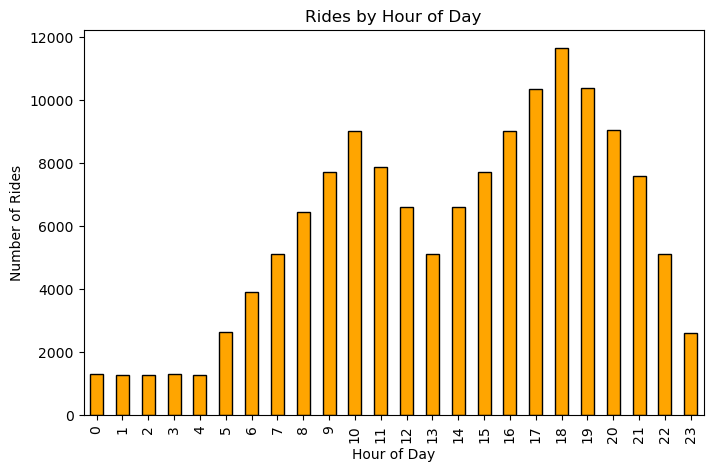

Step 3: Imputing missing values...
Imputation complete. Rows remaining: 141000
Step 4: Dropped unnecessary columns.
Final columns:
 - Vehicle Type
 - Pickup Location
 - Drop Location
 - Avg VTAT
 - Avg CTAT
 - Reason for cancelling by Customer
 - Payment Method
 - is_cancelled
 - hour_of_day
Data cleaning complete. Cleaned data saved to clean_uber_rides_2024.csv


In [91]:
clean_and_save_data(RAW_DATA_FILE, CLEANED_DATA_FILE)

### Load Raw Data for Exploration

In [82]:
uber_df = load_data(RAW_DATA_FILE)
uber_df.columns = uber_df.columns.str.strip()  # fix column names

info = get_basic_info(uber_df)

print("--- Basic Dataset Info ---")
print(f"Number of rows: {info['shape'][0]}")
print(f"Number of columns: {info['shape'][1]}")
print("Columns:")
for col in info['columns']:
    print(f" - {col}")

--- Basic Dataset Info ---
Number of rows: 150000
Number of columns: 21
Columns:
 - Date
 - Time
 - Booking ID
 - Booking Status
 - Customer ID
 - Vehicle Type
 - Pickup Location
 - Drop Location
 - Avg VTAT
 - Avg CTAT
 - Cancelled Rides by Customer
 - Reason for cancelling by Customer
 - Cancelled Rides by Driver
 - Driver Cancellation Reason
 - Incomplete Rides
 - Incomplete Rides Reason
 - Booking Value
 - Ride Distance
 - Driver Ratings
 - Customer Rating
 - Payment Method


### Overall Cancellation Rate

--- Overall Cancellation Rate ---


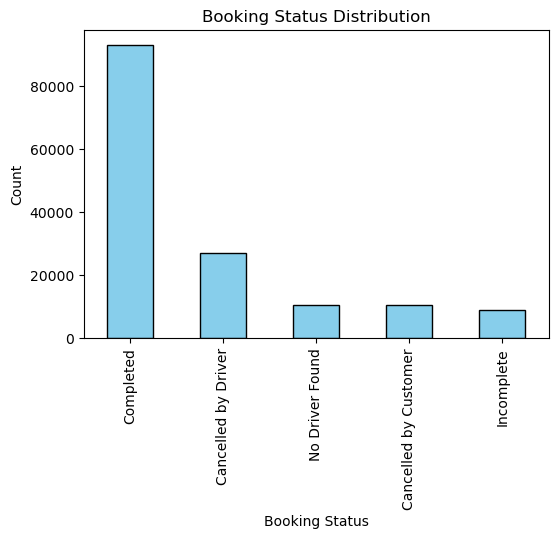

The overall cancellation rate is: 25.00%


In [80]:
print("--- Overall Cancellation Rate ---")
rate = calculate_cancellation_rate(uber_df)
print(f"The overall cancellation rate is: {rate:.2%}")

### Vehicle with Most Cancellations

--- Vehicle with Most Cancellations ---


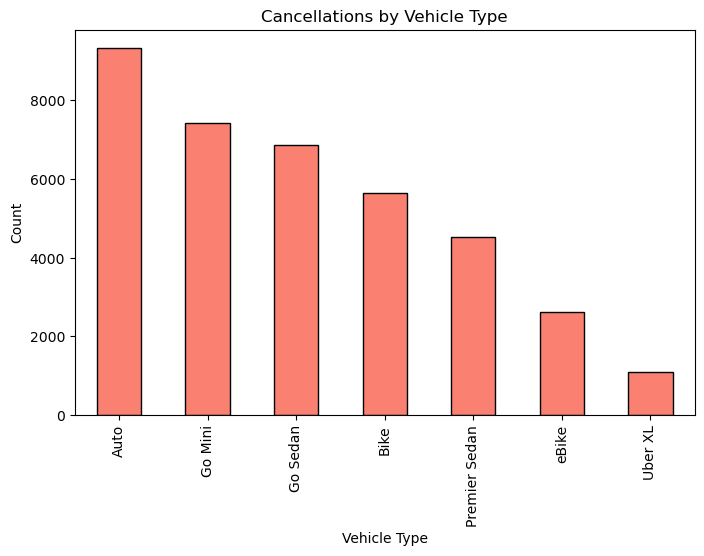

The vehicle type with the most cancellations is: 'Auto'


In [81]:
print("--- Vehicle with Most Cancellations ---")
top_vehicle = find_vehicle_with_most_cancellations(uber_df)
print(f"The vehicle type with the most cancellations is: '{top_vehicle}'")

### Top Customer Cancellation Reason

--- Top Customer Cancellation Reason ---


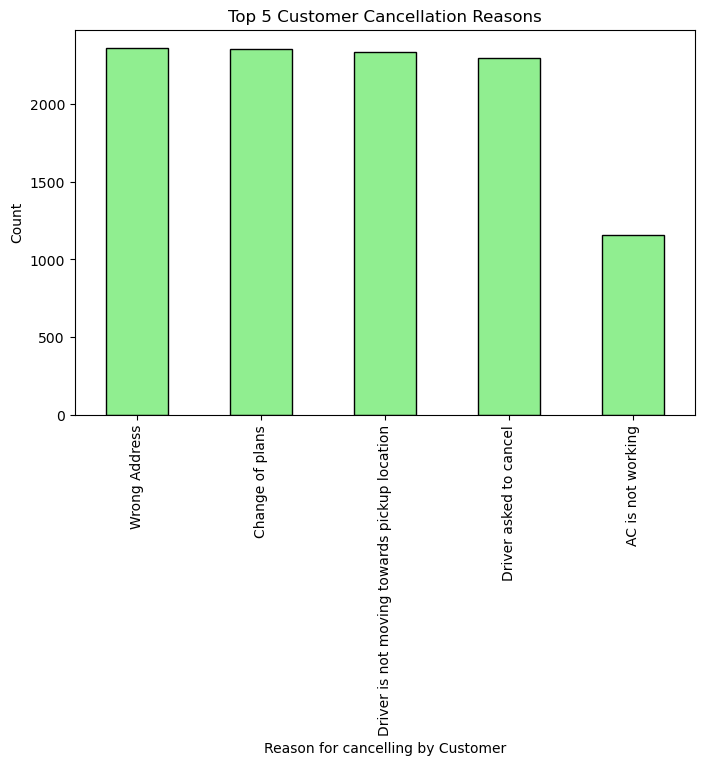

The most common reason for customer cancellations is: 'Wrong Address'


In [60]:
print("--- Top Customer Cancellation Reason ---")
top_reason = find_top_customer_cancellation_reason(uber_df)
print(f"The most common reason for customer cancellations is: '{top_reason}'")

### Peak Cancellation Hour

--- Peak Cancellation Hour ---


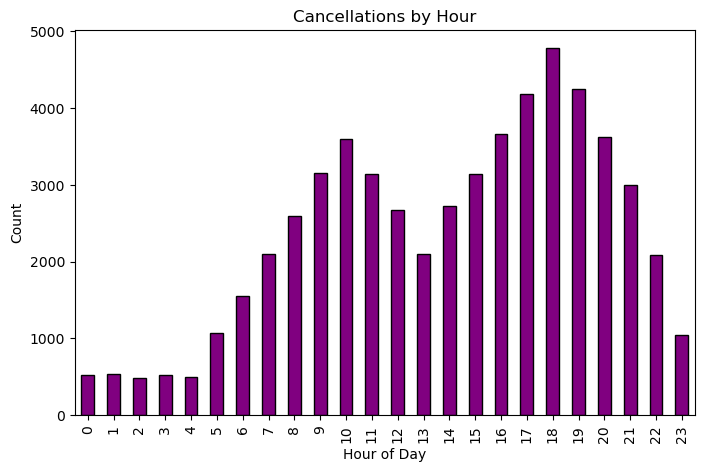

The hour with the most cancellations is: 18:00 - 19:00


In [79]:
print("--- Peak Cancellation Hour ---")
peak_hour = find_peak_cancellation_hour(uber_df)
print(f"The hour with the most cancellations is: {peak_hour}:00 - {peak_hour+1}:00")

### Model Training & Prediction

In [62]:
print("--- Model Training & Prediction ---")
trained_model, model_columns = create_prediction_pipeline(CLEANED_DATA_FILE)

--- Model Training & Prediction ---
Starting model training pipeline...
Data prepared. Features Shape: (141000, 374), Target Shape: (141000,)
Data split. Training samples: 112800, Testing samples: 28200
Model training complete.
Model evaluation complete. Accuracy: 1.0000


### Sample Prediction

In [63]:
print("--- Sample Prediction ---")
sample_ride = {
    'Vehicle Type': 'Go Sedan',
    'Pickup Location': 'Khandasa',
    'Drop Location': 'Malviya Nagar',
    'Avg VTAT': 13.4,
    'Avg CTAT': 25.8,
    'Payment Method': 'UPI',
    'hour_of_day': 8
}

sample_df = pd.DataFrame(sample_ride, index=[0])
sample_encoded = pd.get_dummies(sample_df)
sample_aligned = sample_encoded.reindex(columns=model_columns, fill_value=0)

prediction = trained_model.predict(sample_aligned)
prediction_proba = trained_model.predict_proba(sample_aligned)
result = "Cancelled" if prediction[0] == 1 else "Completed"

print(f"Sample ride data: {sample_ride}")
print(f"Predicted outcome: {result}")
print(f"Prediction probability (0=Completed, 1=Cancelled): {prediction_proba[0]}")

--- Sample Prediction ---
Sample ride data: {'Vehicle Type': 'Go Sedan', 'Pickup Location': 'Khandasa', 'Drop Location': 'Malviya Nagar', 'Avg VTAT': 13.4, 'Avg CTAT': 25.8, 'Payment Method': 'UPI', 'hour_of_day': 8}
Predicted outcome: Completed
Prediction probability (0=Completed, 1=Cancelled): [1. 0.]
